<a href="https://colab.research.google.com/github/purrchinelearning/basic-pytorch/blob/main/FCN_8s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchsummary import summary
from torchvision import transforms,datasets
from torch.utils.data import TensorDataset, DataLoader, Dataset
import cv2
from PIL import Image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

(1080, 1080, 3)


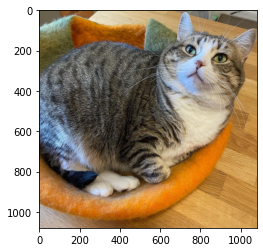

In [3]:
img0 = cv2.imread("/content/drive/MyDrive/poptart.jpg")
img0 = cv2.cvtColor(img0,cv2.COLOR_BGR2RGB)
print(img0.shape)
plt.imshow(img0)
plt.show()

In [4]:
import torchvision.models as models
vgg16 = models.vgg16(pretrained=True)
vgg16

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [5]:
vgg16.classifier = nn.Sequential(*[vgg16.classifier[i] for i in range(0)])
vgg16.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [6]:
class FCN8s(nn.Module):
    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
      outputs = []
      for m in self.pretrained_net.features:
        print(m)
        x = m(x)
        print(x.shape)
        if isinstance(m, nn.MaxPool2d):
          outputs.append(x)
      for i in range(5):
        print(outputs[i].shape)
      # output = self.pretrained_net.features.children()[0](x)
      # for i in range(1,16):
      #   output = self.pretrained_net.features.children()[i](output)
      # x5 = self.pretrained_net.features.children()[16](output)  # size=(N, 512, x.H/32, x.W/32)
      # for i in range(16,23):
      #   output = self.pretrained_net.features.children()[i](output)
      # x4 = self.pretrained_net.features.children()[23](output)  # size=(N, 512, x.H/16, x.W/16)
      # for i in range(23,30):
      #   output = self.pretrained_net.features.children()[i](output)
      # x3 = self.pretrained_net.features.children()[30](output)  # size=(N, 256, x.H/8,  x.W/8)

      score = self.relu(self.deconv1(outputs[4]))               # size=(N, 512, x.H/16, x.W/16)
      print(score.shape)
      score = self.bn1(score + outputs[3])                      # element-wise add, size=(N, 512, x.H/16, x.W/16)
      score = self.relu(self.deconv2(score))            # size=(N, 256, x.H/8, x.W/8)
      score = self.bn2(score + outputs[2])                      # element-wise add, size=(N, 256, x.H/8, x.W/8)
      score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
      score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
      score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
      score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)

      return score  # size=(N, n_class, x.H/1, x.W/1)

In [20]:
model = FCN8s(vgg16,2).to(device)
criterion = torch.nn.BCELoss().to(device)
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01, momentum=0.7)

In [21]:
img0 = cv2.resize(img0,dsize=(1088,1088),interpolation=cv2.INTER_LINEAR) #32*34
from torchvision import transforms
preprocess = transforms.Compose([transforms.ToTensor()])
input_tensor = preprocess(img0)
input_batch = input_tensor.unsqueeze(0)
print(input_batch.shape)
input_batch = input_batch.to('cuda')

with torch.no_grad():
  outputs=model(input_batch) 
print(outputs.shape)

torch.Size([1, 3, 1088, 1088])
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 64, 1088, 1088])
ReLU(inplace=True)
torch.Size([1, 64, 1088, 1088])
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 64, 1088, 1088])
ReLU(inplace=True)
torch.Size([1, 64, 1088, 1088])
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
torch.Size([1, 64, 544, 544])
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 128, 544, 544])
ReLU(inplace=True)
torch.Size([1, 128, 544, 544])
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 128, 544, 544])
ReLU(inplace=True)
torch.Size([1, 128, 544, 544])
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
torch.Size([1, 128, 272, 272])
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 256, 272, 272])
ReLU(inplace=True)
torch.Size([1, 256, 272, 272])
Conv2d(256, 256

In [30]:
print(outputs[0][0][0][0])
print(outputs[0][1][0][0])

tensor(0.1439, device='cuda:0')
tensor(-0.6208, device='cuda:0')


In [47]:
img = torch.squeeze(outputs)
print(img.shape)
img = torch.where(img[0] > img[1] , 255, 0)
img = img.cpu()
img = img.numpy()
img

torch.Size([2, 1088, 1088])


array([[255,   0,   0, ...,   0,   0,   0],
       [  0, 255,   0, ..., 255,   0, 255],
       [  0, 255,   0, ...,   0,   0,   0],
       ...,
       [  0,   0, 255, ...,   0,   0, 255],
       [  0,   0,   0, ..., 255,   0, 255],
       [255, 255, 255, ..., 255, 255, 255]])

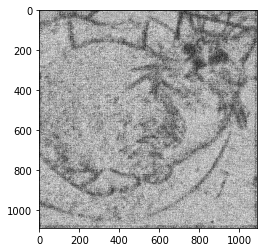

In [49]:
plt.imshow(img,cmap='gray')
plt.show()

torch.Size([2, 1088, 1088])